# Using `alanmode` to reproduce the Bowman+2018 calibration

In this demo, we show how to use the `alanmode` sub-package, which is included in `edges-analysis` purely for the purpose of reroducing much
of the interface of the legacy C code used to generate the results published in [Bowman+2018](https://arxiv.org/abs/1810.05912).

Note that `alanmode` is not intended to be the main way of using the `edges-analysis` pipeline, and it is fairly restrictive in what it offers, 
specifically because it is trying to make it easy to match the legacy code without making mistakes. The parameter names are also not
very pythonic (and sometimes not very intelligible), but are kept matching the corresponding names in the legacy interface, in order to make it
easier to cross-compare. 

For these reasons, this demo is essentialy an "internal" EDGES document, useful for those who have the legacy pipeline available (to be fair, the
legacy pipeline *is* publicly available: https://github.com/edges-collab/alans-pipeline, and it contains a version of this very demo that is less
instructive and more detailed.

## The Data

In this demo we will be using the raw calibration data that was used to obtain the calirbation solutions for Bowman+2018
(in particular the H2 case of Figure 2). We provide convenience methods in the `edges` package to download these datasets.
The results of this download will be cached -- the first run of this tutorial will take a little while, since the spectra
are almost 4 GB in size. 

Throughout this demo we make plots of the various calibration quantities compared to the results of the legacy pipeline. 
The outputs of the legacy pipeline are publicly available, and we also provide a convenience function for obtaining them. 
These outputs exactly match those produced with [nature-paper-case-h2](https://github.com/edges-collab/alans-pipeline/releases/tag/nature-paper-case-h2). 
The C-code was run according to the README of the [alans-pipeline](https://github.com/edges-collab/alans-pipeline) 
repo, specifically by running the `scripts/run-H2-cal` C-shell script.

In [1]:
from edges.data import fetch_b18cal_spectra, fetch_b18cal_calibrated_s11s, fetch_b18_cal_outputs

In [2]:
raw_spectra_dir = fetch_b18cal_spectra()
legacy_outputs_dir = fetch_b18_cal_outputs()
raw_s11_path = fetch_b18cal_calibrated_s11s()

## Using `alanmode`

In [3]:
from pathlib import Path
import numpy as np
from astropy import units as un
import matplotlib.pyplot as plt

plt.style.use("dark_background")

You can use `alanmode` either via a simple CLI, or as a library. Here, we will show how to use the library functions. 
Internally, `alanmode` simply combines the input parameters to manually construct a `CalibrationObservation` and 
from that determines a `Calibrator` instance. In general, the intention is that you would construct both of these
objects yourself, with the greater flexibility afforded by working directly with the objects and their constructor methods.

In [ ]:
# The important function:
from edges.alanmode import alancal

# Classes defining sets of parameters to pass
from edges.alanmode import EdgesScriptParams, Edges2CalobsParams, ACQPlot7aMoonParams

# Functions for reading the outputs of the legacy pipeline
from edges.alanmode import read_modelled_s11s, read_spec_txt, read_specal, LOADMAP, SPEC_LOADMAP

: 

The `alancal` function is the single entry point you need to run a full receiver calibration. 
The function takes three main arguments, each of which is a set of parameters. The first is the
`defparams`, which tells the function where to find the data files it needs, the second is the 
`acqparams`, which tells the function how to deal with the load spectra (which data to average,
and how to downsample it), and the third is the `calparams` which are parameters used in the 
actual calibration, including the order of various S11 models, frequency range in which to 
find calibration solutions, and number of terms for the receiver temperature models.

Here, we specify each required parameter in full. Note that on a first run, the spectrum ACQ files
need to be read, which can take a minute or so. On a second run, the averaged spectra are read in
and this is very fast. However you must be careful to specify `redo_spectra=True` if you change
any of the `ACQPlot7aMoonParams` or else you'll get inconsistent results.

In [ ]:
calobs, calibrator, s11_models, rcv_model, hot_load_loss = alancal(
    defparams = Edges2CalobsParams(
        s11_path = raw_s11_path,
        ambient_acqs = sorted(raw_spectra_dir.glob("Ambient*.acq")),
        hotload_acqs = sorted(raw_spectra_dir.glob("HotLoad*.acq")),
        open_acqs = sorted(raw_spectra_dir.glob("LongCableOpen*.acq")),
        short_acqs = sorted(raw_spectra_dir.glob("LongCableShort*.acq")),
    ),
    acqparams=ACQPlot7aMoonParams(
        delaystart=7200,
        smooth=8,
        fstart=40.0,
        fstop=110.0,
        tload=300.0,
        tcal=1000.0,
        tstart=0,
        tstop=23,  
    ),
    calparams=EdgesScriptParams(
        cfit=6,
        wfit=5,
        Lh=-2,
        wfstart=50.0,
        wfstop=100.0,
        tcold=296,
        thot=399,
        nfit2=27,
        nfit3=11,
        lna_poly=0
    ),
)
  

Reading LongCableOpen_01_2015_243_14_00_00_lab.acq: 2582lines [00:02, 1256.81lines/s]
Reading LongCableOpen_01_2015_244_00_00_00_lab.acq: 6836lines [00:05, 1235.20lines/s]
Reading LongCableOpen_01_2015_245_00_00_00_lab.acq: 464lines [00:00, 1621.37lines/s]
Reading LongCableShorted_01_2015_241_04_00_00_lab.acq: 5495lines [00:04, 1243.63lines/s]
Reading LongCableShorted_01_2015_242_00_00_00_lab.acq: 6803lines [00:04, 1366.35lines/s]
Reading LongCableShorted_01_2015_243_00_00_00_lab.acq: 3959lines [00:02, 1626.80lines/s]


Since the Bowman+2018 results are one of the main motivations for having `alanmode` at all, we also provide convenience methods for 
setting up the parameters with these parameters as defaults:

In [ ]:
calobs_default, calibrator_default, *_ = alancal(
    defparams = Edges2CalobsParams(
        s11_path = raw_s11_path,
        ambient_acqs = sorted(raw_spectra_dir.glob("Ambient*.acq")),
        hotload_acqs = sorted(raw_spectra_dir.glob("HotLoad*.acq")),
        open_acqs = sorted(raw_spectra_dir.glob("LongCableOpen*.acq")),
        short_acqs = sorted(raw_spectra_dir.glob("LongCableShort*.acq")),
    ),
    acqparams=ACQPlot7aMoonParams.bowman_2018_defaults(),
    calparams=EdgesScriptParams.bowman_2018_defaults(),
)
  

We can check that these are the same:

In [ ]:
calibrator_default == calibrator

True

### Check Modelling of S11's

In [ ]:
legacy_case = legacy_outputs_dir / "H2Case-fittpfix"

In [ ]:
legacy_s11m = read_modelled_s11s(legacy_case/ "s11_modelled.txt")

The legacy pipeline outputs the modelled S11 files *before* cutting down the frequency range to the final calibration
frequencies. While the `alancal` function performs the modelling and cutting in the same sequence as the legacy code,
the final modelled S11's we have access to are already cut. So here we cut the S11's from the legacy pipeline:

In [ ]:
mask = (legacy_s11m['freqs']>=50*un.MHz) & (legacy_s11m['freqs']<=100*un.MHz) 

In [ ]:
legacy_s11m = legacy_s11m[mask]

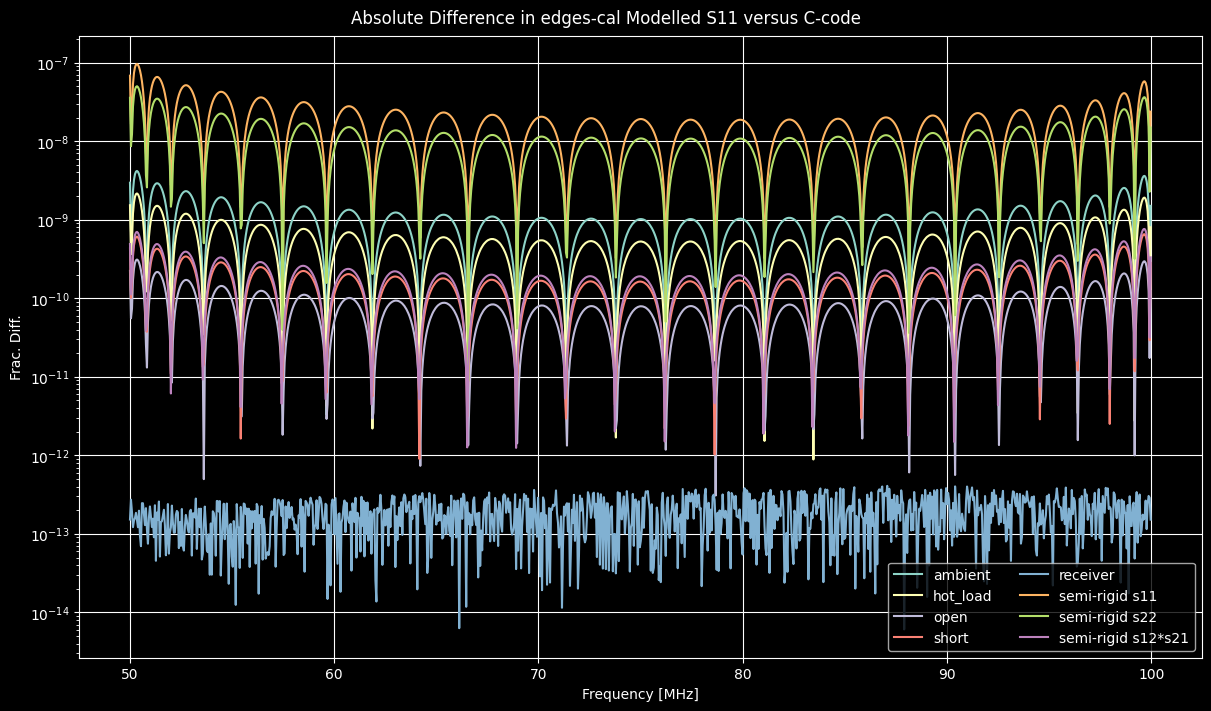

In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(12, 7))

for i, (name, load) in enumerate(calobs.loads.items()):
    ax.plot(calobs.freqs, np.abs(load.s11.s11 - legacy_s11m[name])/np.abs(legacy_s11m[name]), label=name)
    
ax.set_yscale('log')
ax.set_ylabel("Frac. Diff.")
        
# Also plot the semi-rigid and receiver S11's
ax.plot(calobs.freqs, np.abs(calobs.receiver.s11 - legacy_s11m['receiver'])/np.abs(legacy_s11m['receiver']), label='receiver')
sp = hot_load_loss.sparams
ax.plot(calobs.freqs, np.abs(sp.s11 - legacy_s11m['semi_rigid s11'])/np.abs(legacy_s11m['semi_rigid s11']), label=f'semi-rigid s11')
ax.plot(calobs.freqs, np.abs(sp.s22 - legacy_s11m['semi_rigid s22'])/np.abs(legacy_s11m['semi_rigid s22']), label=f'semi-rigid s22')
ax.plot(calobs.freqs, np.abs(sp.s12**2 - legacy_s11m['semi_rigid s12'])/np.abs(legacy_s11m['semi_rigid s12']), label=f'semi-rigid s12*s21')
    
    
ax.legend(ncols=2)
ax.grid(True)
ax.set_xlabel("Frequency [MHz]")
fig.suptitle("Absolute Difference in edges-cal Modelled S11 versus C-code");

### Check Spectrum Averaging

Now we turn to checking the averaged spectrum values. First, we define a function to read all of 
averaged spectrum files produced by the legacy pipeline. This simply wraps a function already 
provided by `edges.alanmode` (i.e. `read_spec_txt`), and puts the outputs into a nice dictionary
with keys that match the conventions of `edges`. 

Furthermore, note that, like the modelled S11s, the averaged spectra are written to file in the 
legacy pipeline before they are cut out to the final calibration frequency range (`wfstart`, `wfstop`).
While we match the same sequence of frequency range cutting in `alancal`, the final spectra
we have access to (without undue effort) have been cut, so we cut down the legacy values to the same
range. The values *outside* this range are of no consequence to the calibration in any case.

In [ ]:
def read_all_avspec(direc: Path, flow, fhigh):
    spec = {}
    allfiles = direc.glob("spe_*r.txt")
    for fl in allfiles:
        load = SPEC_LOADMAP[fl.name.split("_")[1][:-5]]
        s = read_spec_txt(fl)
        freq = s.freqs
        mask = (freq >= flow) * (freq <= fhigh)
        spec[load] = s.data.squeeze()[mask]
        
    return freq[mask], spec

In [ ]:
spfreq, legacy_spec = read_all_avspec(legacy_case, flow=calobs.freqs.min(), fhigh=calobs.freqs.max())

Text(0.5, 1.0, 'Raw spectra differences')

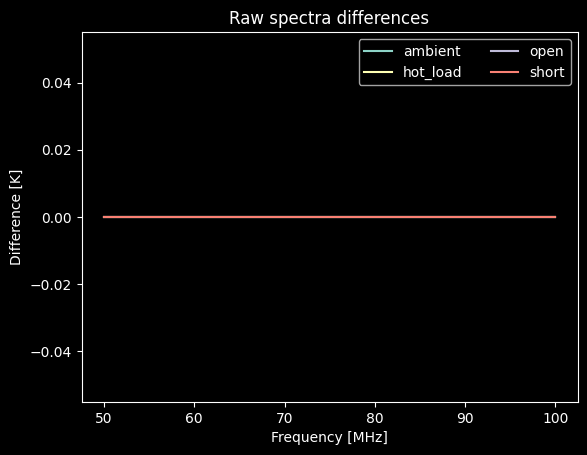

In [ ]:
for i, load in enumerate(legacy_spec):
    plt.plot(
        calobs.freqs, 
        calobs.averaged_spectrum(calobs.loads[load], t_load=300, t_load_ns=1000) - legacy_spec[load],
        label=load
    )
plt.legend(ncols=2)
plt.ylabel("Difference [K]")
plt.xlabel("Frequency [MHz]")
plt.title("Raw spectra differences")

Nicely enough, all four loads have differences of exactly zero compared to the legacy code. 
**NOTE** however that this exact correspondence is achieved due to a rounding of the 
values to 6 decimal places upon writing the files in the legacy pipeline. Since that pipeline
uses these files for further processing (instead of passing the original values in memory onto
the calibration), we mimick that effect in `alancal` by rounding the spectrum values.

### Check Hot Load Loss

In [ ]:
legacy_loss = np.genfromtxt(legacy_case / "hot_load_loss.txt")

Text(0.5, 1.0, 'Difference in hot load loss model')

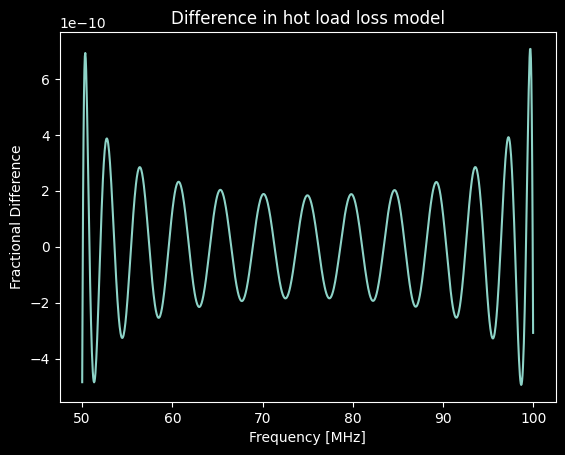

In [ ]:
plt.plot(calobs.freqs, calobs.hot_load.loss / legacy_loss[mask, 1] - 1)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Fractional Difference")
plt.title("Difference in hot load loss model")

### Check Calibration Coefficients

Now we finally turn to the end-products: the calibration temperatures. The output calbration solutions from 
the legacy pipeline specify the scale/offset temperatures in terms of their deviation from initial guesses,
 `t_load_ns` and `t_load` respectively. We pass the values of these guesses (defined when we ran `alancal`)
 to bring the outputs into line with the standard specification of the `edges` code, which are `Tsca` and `Toff`.

In [ ]:
legacy_calibrator = read_specal(legacy_case / "specal.txt", t_load=300, t_load_ns=1000)

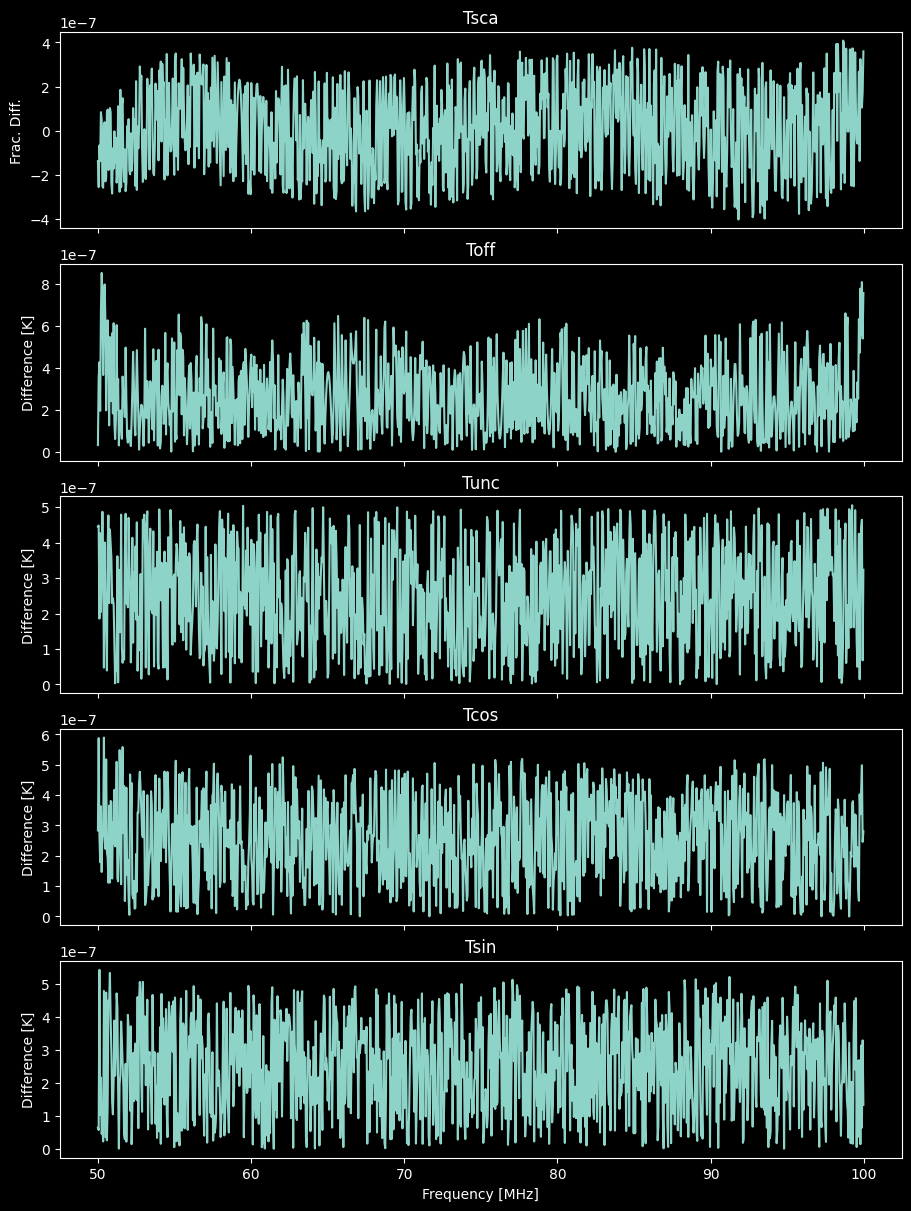

In [ ]:
caltemps = ['Tsca', 'Toff', 'Tunc', 'Tcos', 'Tsin']

fig, ax = plt.subplots(len(caltemps), 1, sharex=True, constrained_layout=True, figsize=(9, 12))


for i, name in enumerate(caltemps):
    if name=='Tsca':
        # Scaling temperature, plot the ratio
        ax[i].plot(calobs.freqs, np.abs(getattr(calibrator, name) / getattr(legacy_calibrator, name)) - 1)
        ax[i].set_ylabel("Frac. Diff.")
    else:
        ax[i].plot(calobs.freqs, np.abs(getattr(calibrator, name) - getattr(legacy_calibrator, name)))
        ax[i].set_ylabel("Difference [K]")

    ax[i].set_title(name)
    
    
ax[-1].set_xlabel("Frequency [MHz]");